In [1]:
import torch as torch
import torchvision as tv
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.image as image
from torch.utils.data import DataLoader
import numpy as np
import os
import os.path
from torch import nn
from pdb import set_trace
from utils import show_images, show_outputs, Downsample, Noise, SSIM
from dataset import MNISTsuperimposed
from models import UpsamplingTransformer, Transformer

In [2]:
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     Downsample(),
     Noise(mean=0, dev=0.01)
     ])
target_transform= transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor()
     ])
train_superimposed = MNISTsuperimposed("./MNIST data/train", train = True, download = True, transform = transform, target_transform=target_transform)
test_supserimposed = MNISTsuperimposed("./MNIST data/test", train = False, download = True, transform = transform, target_transform=target_transform)

In [3]:
trainset = DataLoader(train_superimposed, batch_size=64, shuffle=False)

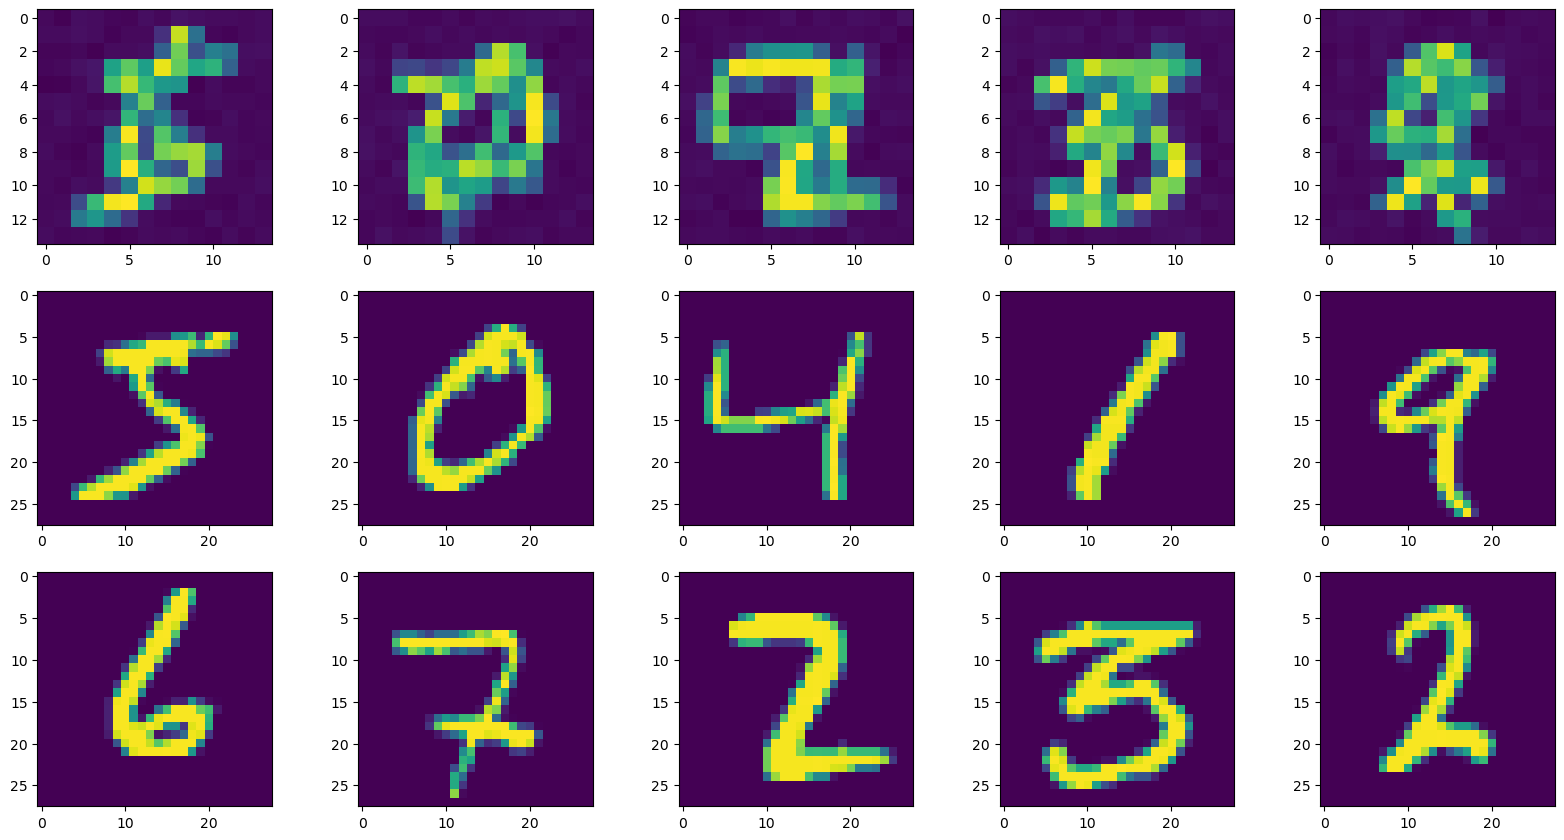

In [4]:
inputs, outputs = next(iter(trainset))
show_images(inputs, outputs)

In [5]:
model = UpsamplingTransformer(
    d_model=288,
    encoder_feedforward=1024,
    decoder_feedforward=1024,
    encoder_heads=288,
    decoder_heads=288,
    num_decoder_layers=1,
    num_encoder_layers=1,
    upscale=1
).cuda()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
Huber = nn.HuberLoss()
ssim = SSIM()
print('Number of model parameter: '+str(sum([parameter.numel() for parameter in model.parameters()])))

Number of model parameter: 2301865


In [6]:
epochs = 100
train_loss = []
flag = True
for epoch in range(epochs):
    for i, (inputs, targets) in enumerate(trainset):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = Huber(targets.to(device), outputs.to(device))
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if i % 100 == 99:
            print('[%d, %5d] loss batch : %.6f' %
                  (epoch + 1, i + 1, loss.item()))
        
print('Finished Training')
flag = False

[1,   100] loss batch : 0.075088
[1,   200] loss batch : 0.068103
[1,   300] loss batch : 0.061413
[1,   400] loss batch : 0.056028
[1,   500] loss batch : 0.049879
[1,   600] loss batch : 0.046408
[1,   700] loss batch : 0.044053
[1,   800] loss batch : 0.039641
[1,   900] loss batch : 0.037270
[2,   100] loss batch : 0.034586
[2,   200] loss batch : 0.033854
[2,   300] loss batch : 0.032298
[2,   400] loss batch : 0.031526
[2,   500] loss batch : 0.029320
[2,   600] loss batch : 0.029072
[2,   700] loss batch : 0.028639
[2,   800] loss batch : 0.026711
[2,   900] loss batch : 0.025842
[3,   100] loss batch : 0.025247
[3,   200] loss batch : 0.025260
[3,   300] loss batch : 0.024459
[3,   400] loss batch : 0.024498
[3,   500] loss batch : 0.023537
[3,   600] loss batch : 0.023842
[3,   700] loss batch : 0.023834
[3,   800] loss batch : 0.022763
[3,   900] loss batch : 0.021951
[4,   100] loss batch : 0.022260
[4,   200] loss batch : 0.022300
[4,   300] loss batch : 0.021532
[4,   400]

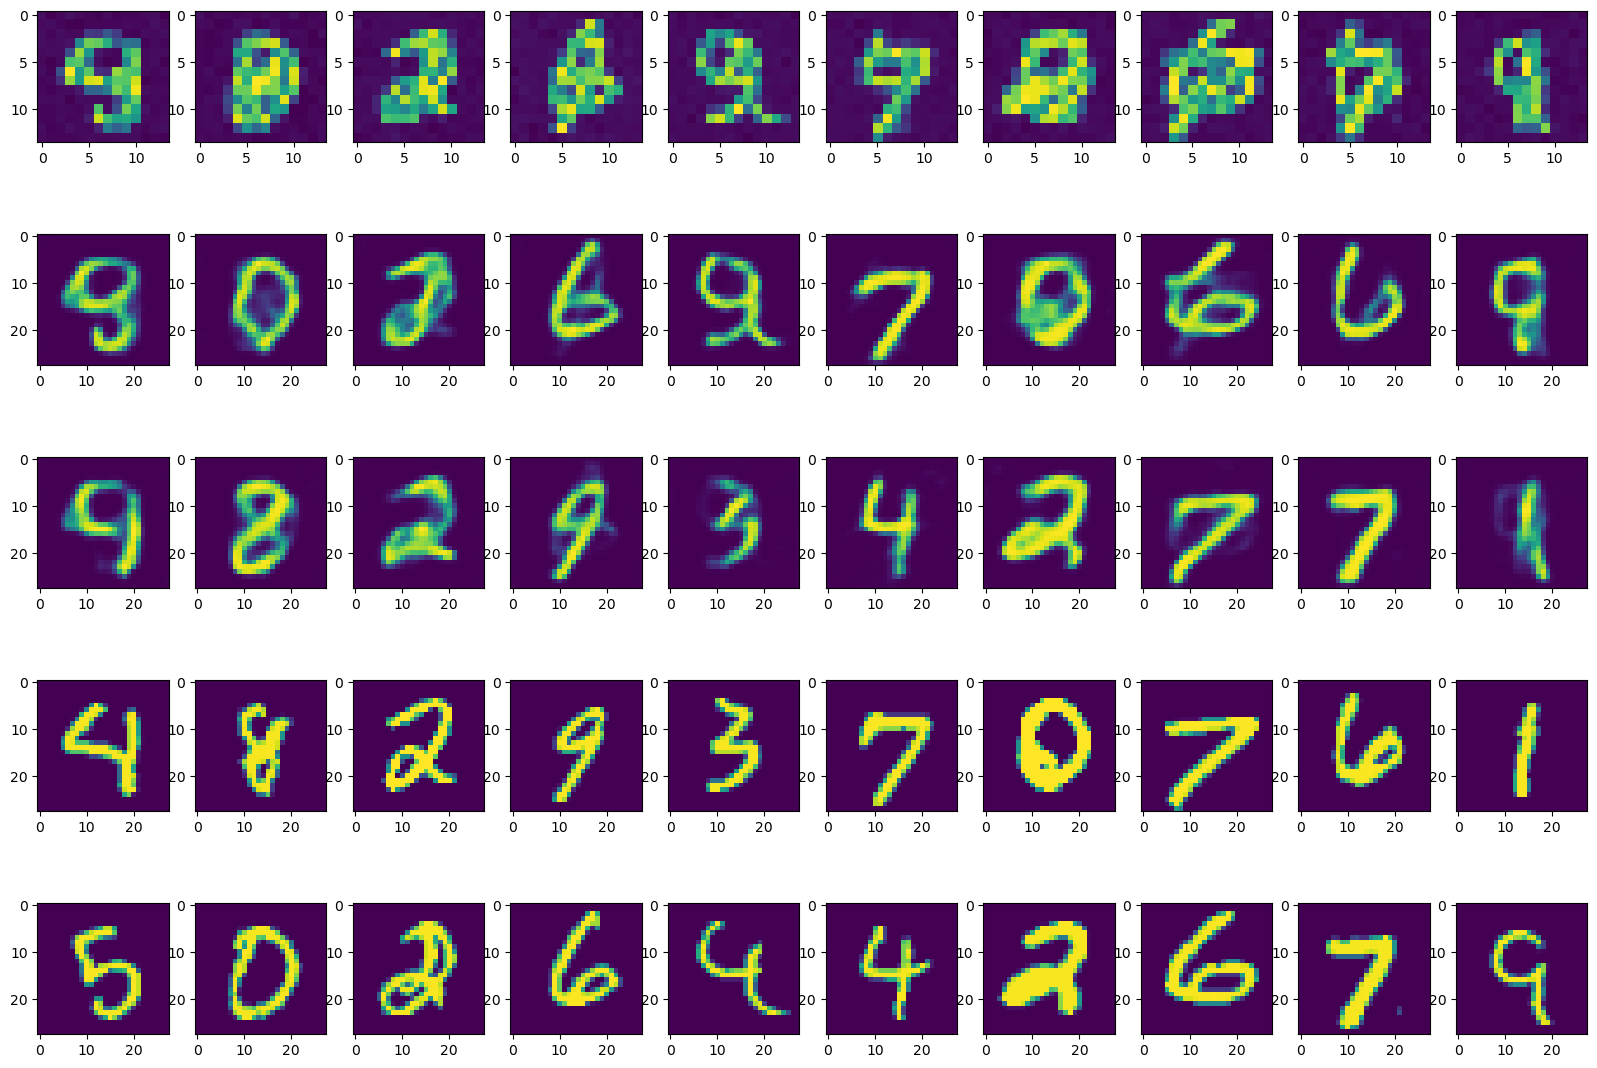

In [8]:
testset = DataLoader(test_supserimposed, batch_size=64, shuffle=True)
inputs,targets = next(iter(testset))
outputs = model(inputs.to(device))
show_outputs(outputs, targets, inputs, num_images=10)

In [ ]:
# Save model

SAVEPATH = './checkpoints/UpsampleDisambDenoiseCheckpointNew.pt'
if os.path.isfile(SAVEPATH):
    filename = input(SAVEPATH +' already exists. Choose another file')

SAVEPATH = './checkpoints/filename'
torch.save(model.state_dict(), SAVEPATH)

In [32]:
# Chop of the last two layers
# Reinitialize new ones
# Freeze the rest of the network
# Train last layers with an incremental learning rates over new dataset
# Release some of the middle layers with a lower learning rates

# Train the feature extractor and freeze it  

# Direction 2:
# Use pretrained resnet weights and shave off the last two layers and extract 

def show_outputs(outputs, targets, inputs,iterator, num_images= 4, savefig = True):
    
    fig = plt.figure(figsize = (20, 14))
    rows = 5
    for i in range(0, rows*num_images):
        if i >=0 and i < num_images:
            fig.add_subplot(rows, num_images, i+1)
            plt.imshow(inputs[i%num_images,0].detach().cpu())
        
        if i >= num_images and i < 2*num_images:
            fig.add_subplot(rows, num_images, i+1)
            plt.imshow(outputs[i%num_images,0].detach().cpu())
        
        if i >= 2*num_images and i < 3*num_images:
            fig.add_subplot(rows, num_images, i+1)
            plt.imshow(outputs[i%num_images, 1].detach().cpu())
        
        if i >= 3*num_images and i < 4*num_images:
            fig.add_subplot(rows, num_images, i+1)
            plt.imshow(targets[i%num_images, 0].detach().cpu())
            
        if i >= 4*num_images and i < 5*num_images:
            fig.add_subplot(rows, num_images, i+1)
            plt.imshow(targets[i%num_images, 1].detach().cpu())

    if savefig:
        fig.savefig('./figures/FinalResults'+str(iterator)+'.png')

In [34]:
testset = DataLoader(test_supserimposed, batch_size=10, shuffle=True)
results = []
for i, (inputs, targets) in enumerate(testset):
    outputs = model(inputs.to(device))
    loss = Huber(targets.to(device), outputs)
    results.append((inputs, outputs, targets, loss))
    show_outputs(outputs, targets, inputs, iterator=i)
# TransformerOutputs = torch.cat([result[1] for result in results], axis = 0)
# inputs = torch.cat([result[0] for result in results], axis = 0)
# targets = torch.cat([result[2] for result in results], axis = 0)


/tmp/ipykernel_54587/624293400.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize = (20, 14))


KeyboardInterrupt: 

In [30]:
print(targets.shape)

torch.Size([50, 2, 28, 28])
